In [2]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from RoomObjects import Room, Object

In [47]:
def add_sofa(room, disp = False):
    """ Add a sofa to the room. The sofa is initially placed in the centre of the room. 
        It cannot rotate the sofa, but the position will be optimized. 
        If there is already a sofa in the room, this function will not add another one.
    
        Parameters:
        room (Room): Room object to add the sofa to.
        disp (bool): If True, the room will be displayed with the new sofa.
    """

    W, L = room.width, room.length

    sofa_count = room.count('sofa')
    print(f"sofa count: {sofa_count}")
    
    if sofa_count == 0:
        print("There is no sofa in this room. Adding one now.")
        
        if W < L:
            room.moving_objects += [Object('sofa', room.center, min(W/3, 3), 1)]
        else: 
            room.moving_objects += [Object('sofa', room.center, 1, min(L/3, 3))]
        
        sofa = room.find('sofa')

    elif sofa_count == 1: 
        print("There is a sofa in this room. Adding a second one now.")
        old_sofa = room.find('sofa')
        sofa = Object('sofa', room.center, old_sofa.length, old_sofa.width)
        room.moving_objects += [sofa]
    
    else: 
        print("There are multiple sofas in this room. Not adding another one.")
        return

    def objective(position):

        x, y = position
        out = 0

        ## Constraint: sofa must be within the room
        out += room.boundary_constraint(x, y, sofa, 100)

        ## Constraint: sofa must not overlap with other objects
        out += room.intersection_constraint(x, y, sofa, 5)

        ## Constraint: sofa should be close to the focal point of the room (perpendicularly)
        focal_point = room.focal_point(sofa)
        if sofa_count == 0:
            if focal_point[0] == 0:
                place = (3, focal_point[1])
            if focal_point[0] == room.width:
                place = (room.width - 3, focal_point[1])
            if focal_point[1] == 0:
                place = (focal_point[0], 3)
            if focal_point[1] == room.length:
                place = (focal_point[0], room.length - 3)
            out += (x - place[0])**2 + (y - place[1])**2

        if sofa_count == 1:
            mid_x, mid_y = (old_sofa.position[0] + focal_point[0])/2, (old_sofa.position[1] + focal_point[1])/2
            dist = (old_sofa.position[0] - mid_x)**2 + (old_sofa.position[1] - mid_y)**2
            out += ((x - mid_x)**2 + (y - mid_y)**2 - dist)**2 
            ## Constraint: sofas should be aligned with each other
            ps = sofa.get_corners(x, y)
            old_ps = old_sofa.get_corners(old_sofa.position[0], old_sofa.position[1])
            min_corner_distance = np.inf
            for i in range(4):
                k = (i + 2)%4
                dist = (ps[i][0] - old_ps[k][0])**2 + (ps[i][1] - old_ps[k][1])**2
                if dist < min_corner_distance:
                    min_corner_distance = dist

            out += min_corner_distance

        return out 
        
    res = minimize(objective, sofa.position, method='Nelder-Mead')
    sofa.position = res.x

    if disp:
        room.draw()

    return

def add_TV(room, disp = False):
    """ Add a TV to the room. The TV is initially placed at the focal point of the room. 
        It cannot rotate the TV, but the position will be optimized. 
        If there is already a TV in the room, this function will not add another one.
    
        Parameters:
        room (Room): Room object to add the TV to.
        disp (bool): If True, the room will be displayed with the new TV.
    """

    tv = room.find('tv')
    if tv is not None:
        print("There is already a TV in this room.")
        return
    else: 
        tv = Object('tv', 0.0, 1, 1)
        tv = Object('tv', room.focal_point(tv), 1.5, 0.1)
        room.moving_objects += [tv]

    def objective(position):


        x, y = position
        out = 0

        ## Constraint: tv must be within the room
        out += room.boundary_constraint(x, y, tv, 100)

        ## Constraint: tv must not overlap with other objects
        out += room.intersection_constraint(x, y, tv, 5)

        ## Constraint: tv should be equal distance from sofas and chairs 
        sofas = room.find_all('sofa')
        chair = room.find_all('chair')
        if len(sofas + chair) > 0:
            dist = 0
            diff = 0
            for s in sofas + chair:
                dist += ((x - s.position[0])**2 + (y - s.position[1])**2)/len(sofas + chair)

            for s in sofas + chair:
                diff += ((x - s.position[0])**2 + (y - s.position[1])**2 - dist)**2
            
            out += diff
        
        ## Constraint: tv should be against a wall
        if tv.width < tv.length: 
            print("width < length")
            wall_distances = [x - tv.width/2, room.width - x - tv.width/2]#, y - tv.length/2, room.length - y - tv.length/2]
        else: 
            wall_distances = [y - tv.length/2, room.length - y - tv.length/2]
        
        out += 25*min([i**2 for i in wall_distances])

        ## Constraint: tv should be 30 degrees away from windows
        windows = room.find_all('window')
        for window in windows: 
            window_to_tv = np.array([x, y]) - np.array(window.position)
            window_to_tv = window_to_tv/np.linalg.norm(window_to_tv)

            

        return out 
        
    res = minimize(objective, tv.position, method='Nelder-Mead')
    tv.position = res.x
    

    if disp:
        room.draw() 


    return

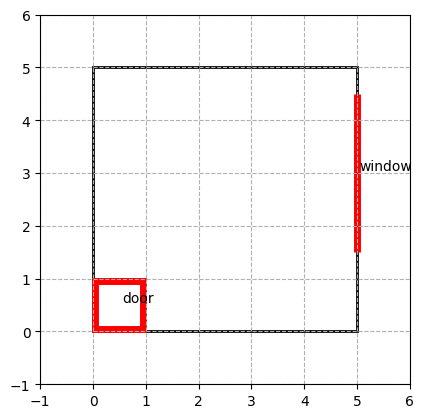

sofa count: 0
There is no sofa in this room. Adding one now.


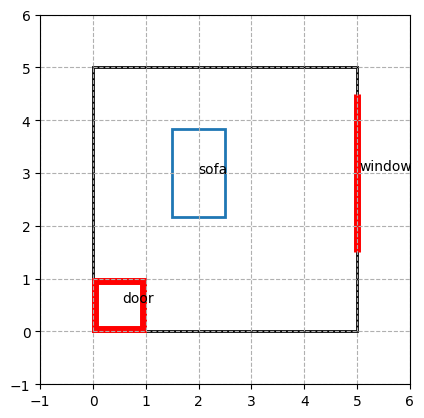

sofa count: 1
There is a sofa in this room. Adding a second one now.


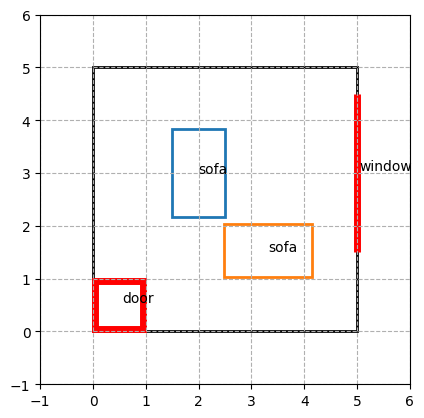

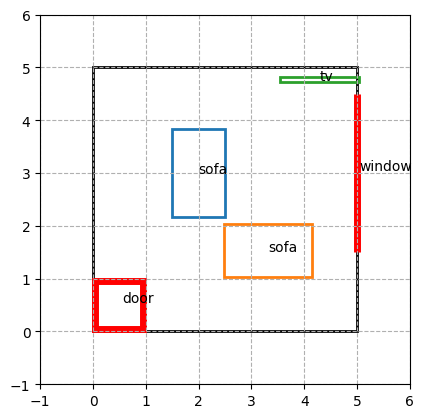

In [48]:
room = Room(5, 5)
room.fixed_objects = [Object('door', [0.5, 0.5], 0.91, 0.91), Object('window', [5, 3], 0, 3)]
room.draw()

add_sofa(room, disp = True)
add_sofa(room, disp = True)
add_TV(room, disp = True)